<a href="https://colab.research.google.com/github/tenoob/Sementic-Segmentation/blob/dev/unet_model_prepared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [2]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [3]:
!pip install patchify
!pip install -U segmentation-models
!pip install mlflow --quiet
!pip install dagshub
#!pip install tensorflow==2.10
#!pip install tensorflow-gpu==2.10
#!pip install git+https://github.com/qubvel/segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.2/211.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (

In [4]:
#from keras.utils import generic_utils
import segmentation_models as sm
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from google.colab.patches import cv2_imshow


Segmentation Models: using `tf.keras` framework.


In [5]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset'

In [6]:
patch_size = 256
scaler = MinMaxScaler()
image_dset = []
mask_dset = []

In [7]:
# read images and masks
#instead of using 8 tiles will be using 7 ,due to ram overflow in google colab
for image_type in ['images', 'masks']:
    image_extension = 'jpg' if image_type == 'images' else 'png'
    for tile_id in range(1,8):
        for image_id in range(1,10):
            image = cv2.imread(f'{root_dir}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
            if image is not None:
                print(f'{root_dir}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}')
                if image_type == 'masks':
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image_width = (image.shape[1]//patch_size)*patch_size
                image_height = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image) #convert img from ndarray to pil.image
                image = image.crop((0,0,image_width,image_height))
                image = np.array(image)  #convert the img back to nparray
                patch_img = patchify(image,(patch_size,patch_size,3),step = patch_size)
                #print(type(patch_img),patch_img.shape)
                for i in range(patch_img.shape[0]):
                    for j in range(patch_img.shape[1]):
                        if image_type == 'images':
                            small_pathes = patch_img[i,j,:,:]
                            small_pathes = scaler.fit_transform(small_pathes.reshape(-1,small_pathes.shape[-1])).reshape(small_pathes.shape)
                            small_pathes = small_pathes[0]  #remove unwanted patchify dimensions
                            image_dset.append(small_pathes)
                        elif image_type == 'masks':
                            small_pathes = patch_img[i,j,:,:]
                            small_pathes = small_pathes[0]  #remove unwanted patchify dimensions
                            mask_dset.append(small_pathes)


/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg
/content/d

In [8]:
print(type(image_dset),type(mask_dset))


<class 'list'> <class 'list'>


In [9]:
image_dset = np.array(image_dset)
mask_dset = np.array(mask_dset)

In [10]:
image_dset.shape , mask_dset.shape

((945, 256, 256, 3), (945, 256, 256, 3))

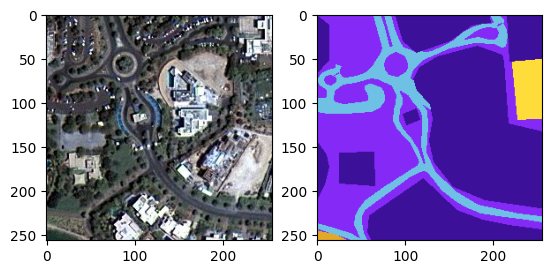

In [11]:
import random

random_number = random.randint(0,len(image_dset))
plt.subplot(121)
plt.imshow(image_dset[random_number])
plt.subplot(122)
plt.imshow(mask_dset[random_number])

In [12]:
label = small_pathes

In [13]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [14]:
def rgb_2_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0] # need just 1 channel now, no 3 channels
  return label_segment

In [15]:
labels = []
for i in range(mask_dset.shape[0]):
    new_label = rgb_2_label(mask_dset[i])
    labels.append(new_label)

In [16]:
labels = np.array(labels)
labels.shape

(945, 256, 256)

In [17]:
labels = np.expand_dims(labels,axis=3)
labels.shape

(945, 256, 256, 1)

In [18]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [19]:
total_classes = len(np.unique(labels))
total_classes

6

In [20]:
labels[2]

array([[[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

array([[[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]], dtype=uint8)
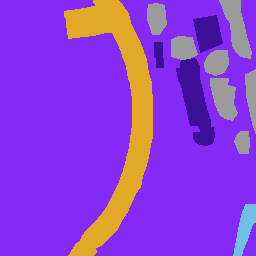

In [21]:
mask_dset[0]

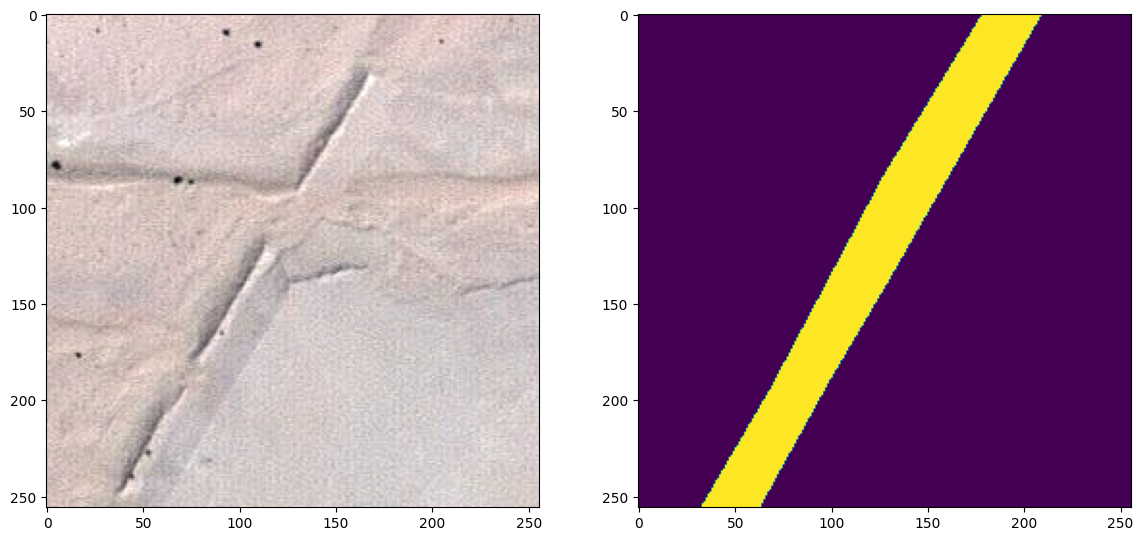

In [22]:
random_image_id = random.randint(0, len(image_dset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [23]:
from tensorflow.keras.utils import to_categorical

categorical_classes = len(np.unique(labels))
categorical_labels = to_categorical(labels,num_classes=categorical_classes)



In [24]:
categorical_labels.shape

(945, 256, 256, 6)

In [25]:
#train Test split

from sklearn.model_selection import train_test_split

x_train , x_test , y_train ,y_test = train_test_split(image_dset,categorical_labels, test_size=0.20 , random_state = 50)

In [26]:
x_train.shape , type(x_train)

((756, 256, 256, 3), numpy.ndarray)

model building

In [27]:
from keras.models import Model
from keras import backend as bend
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D ,Conv2DTranspose ,concatenate ,BatchNormalization ,Lambda


In [28]:
def unet_model(n_class = 5, img_height = 256, img_width = 256 , channels = 1):
    inputs = Input((img_height , img_width , channels))
    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_class ,(1,1), activation="softmax")(c9)
    model = Model(inputs=[inputs], outputs = [outputs])
    return model

In [29]:
def jaccard_coeff(y_true,y_pred):
    y_true = bend.flatten(y_true)
    y_pred = bend.flatten(y_pred)
    interset = bend.sum(y_true*y_pred)
    #print(y_true,y_pred,interset)
    return  (interset + 1.0) / (bend.sum(y_true) + bend.sum(y_pred) - interset + 1.0)

In [30]:
y_true = np.random.rand(16,256,256,6)
y_pred = np.random.rand(16,256,256,6)
print(y_true.shape,y_pred.shape)
result = jaccard_coeff(y_true,y_pred)
print(result.shape)

(16, 256, 256, 6) (16, 256, 256, 6)
()


In [31]:
metrics = ["accuracy" , jaccard_coeff]

In [32]:
import segmentation_models as sm
#sm.set_framework('tf.keras')


In [33]:
#loss
weights = [0.1666,0.1666,0.1666,0.1666,0.1666,0.1666]

dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)


In [34]:
img_height = x_train.shape[1]
img_width = x_train.shape[2]
img_channels = x_train.shape[3]
print(img_height,img_width,img_channels)

256 256 3


In [35]:
def get_model():
    return unet_model(n_class=total_classes,
                      img_height = img_height,
                      img_width = img_width,
                      channels = img_channels)

In [36]:
#model compilation
import tensorflow as tf

#tf.keras.backend.clear_session()

In [37]:
model = get_model()
model.compile(optimizer = "adam" , loss = total_loss , metrics = metrics)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [39]:
## remove not required varaibles

import gc

del image_dset
del mask_dset
del labels
del categorical_classes
del categorical_labels

gc.collect()

106

In [40]:
#settimg up mlflow and dagshub integration
from google.colab import userdata
import requests
import mlflow
import os
from getpass import getpass
import datetime

REPO_NAME = "Sementic-Segmentation"
REPO_OWNER = "tenoob"
USER_NAME = "tenoob"

os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('user')
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('password')

mlflow.set_tracking_uri(userdata.get('uri'))

mlflow.tensorflow.autolog()
mlflow.log_param("task",3)

3

In [41]:
model_history = model.fit(x_train,y_train,
                          batch_size = 16,
                          epochs=5,
                          verbose = 1,
                          validation_data = (x_test,y_test),
                          shuffle = False)

Epoch 1/5
48/48 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.5024 - jaccard_coeff: 0.2268 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 655s 13s/step - loss: 1.0085 - accuracy: 0.5024 - jaccard_coeff: 0.2268 - val_loss: 0.9938 - val_accuracy: 0.5797 - val_jaccard_coeff: 0.2604
Epoch 2/5
48/48 [==============================] - 648s 14s/step - loss: 0.9917 - accuracy: 0.6162 - jaccard_coeff: 0.2992 - val_loss: 0.9805 - val_accuracy: 0.6885 - val_jaccard_coeff: 0.3656
Epoch 3/5
48/48 [==============================] - 643s 13s/step - loss: 0.9699 - accuracy: 0.6938 - jaccard_coeff: 0.4168 - val_loss: 0.9597 - val_accuracy: 0.7258 - val_jaccard_coeff: 0.4468
Epoch 4/5
48/48 [==============================] - ETA: 0s - loss: 0.9605 - accuracy: 0.7186 - jaccard_coeff: 0.4580 

48/48 [==============================] - 645s 13s/step - loss: 0.9605 - accuracy: 0.7186 - jaccard_coeff: 0.4580 - val_loss: 0.9553 - val_accuracy: 0.7473 - val_jaccard_coeff: 0.4845
Epoch 5/5
1/1 [==============================] - 2s 2s/step


2024/03/06 19:05:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdthejlua/model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/03/06 19:05:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [44]:
#saving model
mlflow.tensorflow.log_model(model,"5EpochModel",keras_model_kwargs={"save_format": "h5"})

2024/03/06 19:15:11 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
#loadding model
new_mod = tf.keras.models.load_model(
    '/content/model.h5',
    custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jaccard_coeff':jaccard_coeff}
)

In [68]:
image = np.expand_dims(x_test[0],0)
image.shape

(1, 256, 256, 3)

In [70]:
y_test_argmax = np.argmax(y_test, axis=3)

In [76]:
test_image_number = random.randint(0, len(x_test))

test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)
print(test_image_input.shape)
prediction = new_mod.predict(test_image_input)
print(prediction.shape)
predicted_image = np.argmax(prediction, axis=3)
print(predicted_image.shape)
predicted_image = predicted_image[0,:,:]
print(predicted_image.shape)


(1, 256, 256, 3)
1/1 [==============================] - 0s 287ms/step
(1, 256, 256, 6)
(1, 256, 256)
(256, 256)


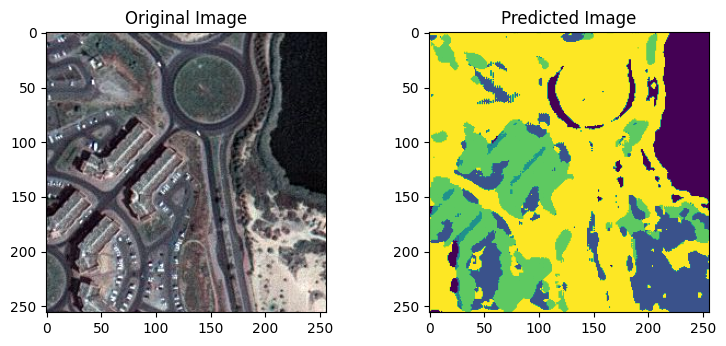

In [77]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

<h1> debug


In [ ]:
!nvidia-smi

Tue Mar  5 19:14:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import mlflow

ModuleNotFoundError: No module named 'mlflow'

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
"""
# Check if a GPU device is available
if tf.config.list_physical_devices('GPU'):
  print('A GPU device is available')
else:
  print('No GPU device is available')"""

"\n# Check if a GPU device is available\nif tf.config.list_physical_devices('GPU'):\n  print('A GPU device is available')\nelse:\n  print('No GPU device is available')"

In [ ]:
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
tf.compat.v1.enable_eager_execution()


In [ ]:
# Get the current device
device_name = tf.config.list_physical_devices('GPU')[0].name

# Check if the model is using the GPU
with tf.device(device_name):
  # Your model code here
  # ...
  model_history = model.fit(x_train,y_train,
                          batch_size = 16,
                          epochs=100,
                          verbose = 1,
                          validation_data = (x_test,y_test),
                          shuffle = False)
  print('The model is using the GPU')

IndexError: list index out of range

In [ ]:
print(x_train.shape)
print(y_train.shape)

(756, 256, 256, 3)
(756, 256, 256, 6)


In [ ]:
print(x_train.dtype)
print(y_train.dtype)

float64
float32


In [ ]:
model.input_shape  , model.output_shape

((None, 256, 256, 3), (None, 256, 256, 6))

In [ ]:
y_true = np.random.rand(16,256,256,6)
y_pred = np.random.rand(16,256,256,6)
result = jaccard_coeff(y_true,y_pred)
print(result.shape)